In [1]:
%load_ext autoreload
%autoreload 2

from setup import setup_project_env
setup_project_env('~/weatherpy-work')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from datasrcs.ibtracs import atlantic_tcs

In [3]:
ds = atlantic_tcs()

/Users/jitang/anaconda/envs/storm_analysis_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (3,21,128,148) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [4]:
post_1970 = ds[ds.season.isin(range(1970, 2019))]

In [5]:
deg = 90 - post_1970.storm_dir
post_1970['storm_dir_rad'] = np.radians(deg)

/Users/jitang/anaconda/envs/storm_analysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
post_1970[['sid', 'season', 'number', 'name', 'iso_time', 'lat', 'lon', 'storm_speed', 'storm_dir', 'storm_dir_rad']].tail()

,sid,season,number,name,iso_time,lat,lon,storm_speed,storm_dir,storm_dir_rad
119054,2018300N25315,2018,40,OSCAR,2018-11-04 00:00:00,59.8000,-14.5000,15.0,54.0,0.628319
119055,2018300N25315,2018,40,OSCAR,2018-11-04 03:00:00,60.2449,-13.3185,15.0,50.0,0.698132
119056,2018300N25315,2018,40,OSCAR,2018-11-04 06:00:00,60.8000,-12.1000,18.0,45.0,0.785398
119057,2018300N25315,2018,40,OSCAR,2018-11-04 09:00:00,61.5472,-10.6887,21.0,42.0,0.837758
119058,2018300N25315,2018,40,OSCAR,2018-11-04 12:00:00,62.4000,-9.1000,22.0,41.0,0.855211


In [10]:
from geopy.distance import great_circle

def calc_deltas(df, shift_periods, debug=False):
    cols = ['sid', 'name', 'iso_time', 'lat', 'lon']
    shifted = df[cols].groupby('sid').shift(shift_periods)
    deltas = df[cols].join(shifted, lsuffix='_1', rsuffix='_0')
    
    lat1 = np.radians(deltas.lat_0)
    lat2 = np.radians(deltas.lat_1)
    delta_lon = np.radians(deltas.lon_1 - deltas.lon_0)
    x = np.sin(delta_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon))
    angles = np.arctan2(y, x)
    
    def dist_nm(row):
        lat0, lat1, lon0, lon1 = row.lat_0, row.lon_0, row.lat_1, row.lon_1
        if np.any(np.isnan([lat0, lat1, lon0, lon1])):
            return np.nan
            
        pt0 = (row.lat_0, row.lon_0)
        pt1 = (row.lat_1, row.lon_1)
        return great_circle(pt0, pt1).nm
    
    dists = deltas.apply(dist_nm, axis=1) 
    speeds = dists / (shift_periods * 6)
    
    return dists, speeds, angles

In [74]:
post_1970 = post_1970[post_1970.iso_time.dt.hour.isin([0, 6, 12, 18])]
dists, speeds, angles = calc_deltas(post_1970, 6)
post_1970_copy = post_1970.copy()

post_1970_copy['speed_calc'] = speeds
post_1970_copy['dist_calc'] = dists
post_1970_copy['angle_calc'] = angles

in_bbox = post_1970_copy

in_bbox = post_1970_copy[
    (post_1970_copy.lat >= 20) & (post_1970_copy.lat <= 30)
    & (post_1970_copy.lon >= -100) & (post_1970_copy.lon <= -65)
]

in_bbox = in_bbox[in_bbox.iso_time.dt.month.isin([8, 9])]

In [75]:
stallers = in_bbox[in_bbox.dist_calc < 100]

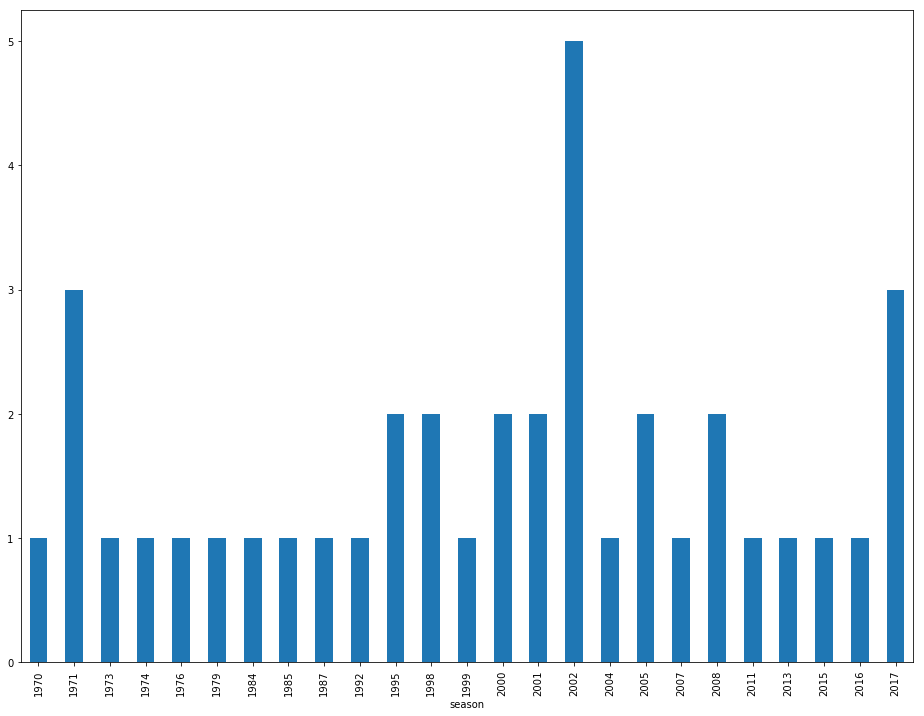

In [76]:
fig = plt.figure(figsize=(16, 12))
unique_byyear = stallers.groupby('season').nunique()['sid']
unique_byyear.plot(kind='bar')

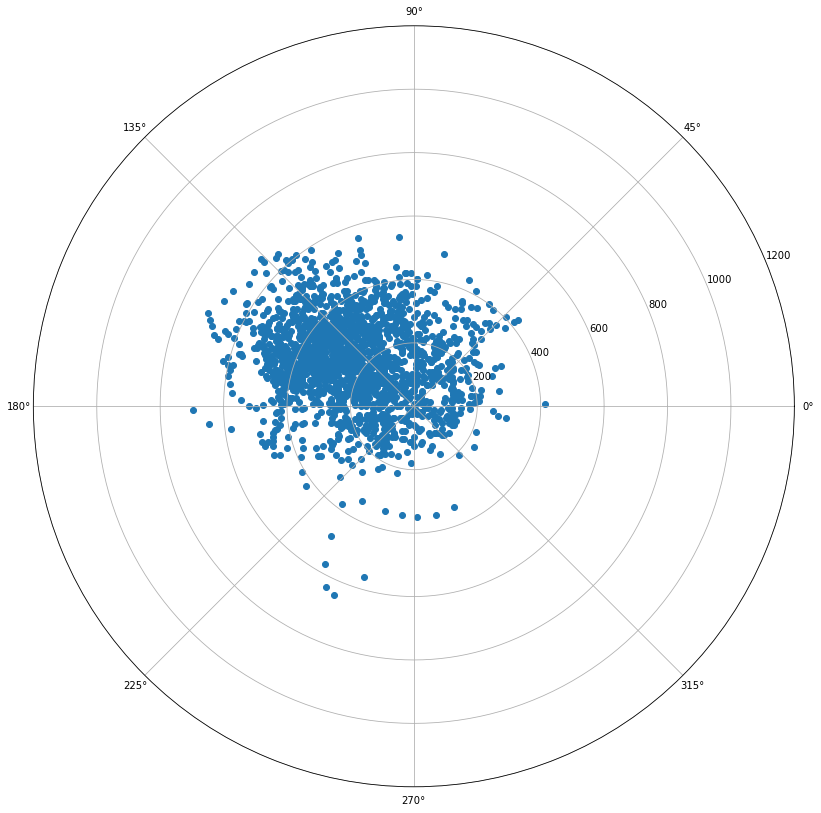

In [77]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='polar')
ax.scatter(in_bbox.angle_calc, in_bbox.dist_calc)

ax.set_rmax(1200)